# Optimizing Model with HParams Dashboard

## Hidden Layers, Drop Rates, and Optimizer Functions

### Hidden layers and Nodes

Reducing number of `Layers` would need more `epochs` ~ 500-1000
```python
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))
```

Using too few neurons in the `Layers` will result in underfitting.

Using too many neurons in the `Layers` may result in overfitting and taking more time to train.

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following: The number of hidden neurons should be between the size of the input layer and the size of the output layer. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. The number of hidden neurons should be less than twice the size of the input layer. [link](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

### Activation functions 

Activation functions work best in their default hyperparameters that are used in popular frameworks such as Tensorflow and Pytorch.

`ReLU` function is widely used.

Activation functions for Classification ML: `softmax`, `sigmoid`, `Tanh`.

### In this project, `ReLU` seems to be the best fit for activation function.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import this module's functions
from functions import (
    SuperHighVariationScaler,
    map_num_to_string,
    map_string_to_num,
    sparse_array,
    early_stopper,
)

## Import data

In [3]:
file_name_all_data = "data/_nanocomposite_data.csv"
all_data = pd.read_csv(file_name_all_data, index_col=None, header=0)
# Drop columns which are not used for now
all_data_clean = all_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)
all_data_clean = map_string_to_num(all_data_clean)
all_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   polymer_1     5000 non-null   int64  
 1   filler_1      5000 non-null   int64  
 2   wt_l1         5000 non-null   float64
 3   conductivity  5000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 156.4 KB


## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [4]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = SuperHighVariationScaler()

### Splitting data to training and testing sets

In [5]:
training_data, testing_data = train_test_split(
    all_data_clean, test_size=0.2, random_state=25
)

In [6]:
# Split into input features (X) and output labels (Y) variables
X_training = training_data.drop("conductivity", axis=1).values
Y_training = training_data[["conductivity"]].values

# Pull out columns for X (data to train with) and Y (value to predict)
X_testing = testing_data.drop("conductivity", axis=1).values
Y_testing = testing_data[["conductivity"]].values

### Scaling data

In [7]:
# Scale both the training inputs and outputs
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# Training and test data are scaled with the same scaler.
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

## Run GridSearch with the HParams

https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

There are many other hyperparameters that can be tuned in that tutorial.

### Set the ranges of Hyperparameters

In [8]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS1 = hp.HParam("num_units_1", hp.Discrete([64, 128]))
HP_NUM_UNITS2 = hp.HParam("num_units_2", hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["adam", "sgd"]))

METRIC_ERROR = "MeanSquaredLogarithmicError"
DISPLAY_NAME = "Mean Squared Logarithmic Error"

with tf.summary.create_file_writer("logs/hparam_tuning").as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ERROR, display_name=DISPLAY_NAME)],
    )

# Create function

Create function to build and compile model each run


In [9]:
def train_test_model(hparams, epochs=300):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Dense(
            hparams[HP_NUM_UNITS1], activation="relu", input_dim=3
        )
    )
    model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
    model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation="relu"))
    model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))

    model.add(tf.keras.layers.Dense(1, activation="linear"))

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=hparams[HP_OPTIMIZER],
        metrics=tf.keras.metrics.MeanSquaredLogarithmicError(),
    )

    model.fit(
        X_scaled_training,
        Y_scaled_training,
        epochs=epochs,
        batch_size=64,
        verbose=0,
        callbacks=[
            early_stopper(
                monitor="mean_squared_logarithmic_error",
                patience=50,
                verbose=0,
            )
        ],
    )

    _, MSLE = model.evaluate(X_scaled_testing, Y_scaled_testing, verbose=0)
    print(f"Mean Squared Logarithmic Error: {MSLE:.4f}")
    return model, MSLE

For each run, log an hparams summary with the hyperparameters and final accuracy:

In [10]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        _, MSLE = train_test_model(hparams, epochs=300)
        tf.summary.scalar(METRIC_ERROR, MSLE, step=1)

Start runs and log them all under one parent directory

In [11]:
session_num = 0
for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for num_units_1 in HP_NUM_UNITS1.domain.values:
        for num_units_2 in HP_NUM_UNITS2.domain.values:
            for optimizer in HP_OPTIMIZER.domain.values:
                hparams = {
                    HP_NUM_UNITS1: num_units_1,
                    HP_NUM_UNITS2: num_units_2,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                }
                run_name = "run-%d" % session_num
                print("--- Starting trial: %s" % run_name)
                print({h.name: hparams[h] for h in hparams})
                run("logs/hparam_tuning/" + run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'num_units_1': 64, 'num_units_2': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Mean Squared Logarithmic Error: 0.0063
--- Starting trial: run-1
{'num_units_1': 64, 'num_units_2': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
Mean Squared Logarithmic Error: 0.2105
--- Starting trial: run-2
{'num_units_1': 64, 'num_units_2': 32, 'dropout': 0.1, 'optimizer': 'adam'}
Mean Squared Logarithmic Error: 0.0067
--- Starting trial: run-3
{'num_units_1': 64, 'num_units_2': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
Mean Squared Logarithmic Error: 0.2105
--- Starting trial: run-4
{'num_units_1': 128, 'num_units_2': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Mean Squared Logarithmic Error: 0.0063
--- Starting trial: run-5
{'num_units_1': 128, 'num_units_2': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
Mean Squared Logarithmic Error: 0.7056
--- Starting trial: run-6
{'num_units_1': 128, 'num_units_2': 32, 'dropout': 0.1, 'optimizer': 'adam'}
Mean Squared Logarithmic Error: 0.0063
--- Starting 

## Visualization with TensorBoard

First, we need to load the tensorboard

In [12]:
%load_ext tensorboard

In [13]:
%tensorboard --logdir logs/hparam_tuning

## Validating the results

During these tests, the "SGD" optimizer did not perform as well as the "Adam" optimizer.

Let's try to model with one of the best results.

1. The first dense layer is with 64 units

2. The second dense layer is with 16 units

3. Each of the dense layers has dropout rate of 0.1 

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer='adam',
    metrics=tf.keras.metrics.MeanSquaredLogarithmicError(),
)

model.fit(
    X_scaled_training,
    Y_scaled_training,
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[
        early_stopper(
            monitor="mean_squared_logarithmic_error",
            patience=50,
            verbose=0,
        )
    ],
)

## Plotting predicting vs testing data

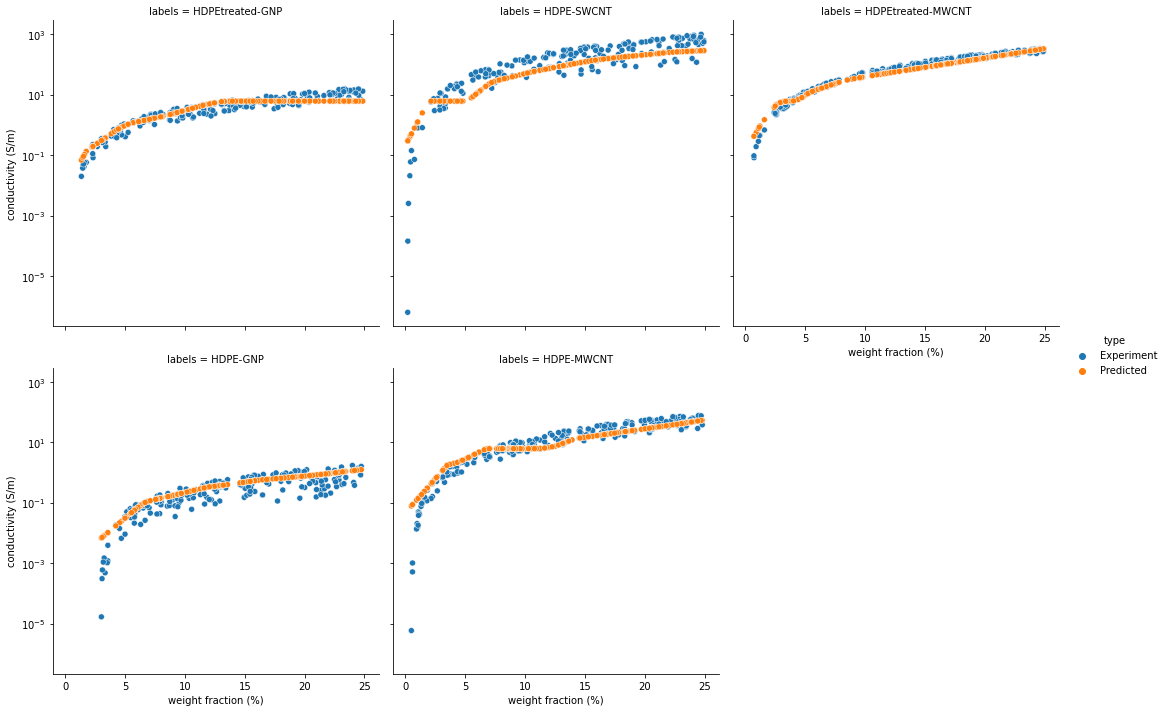

In [17]:
# Calculate predictions
X_scaled_testing = X_scaler.transform(X_testing)

predicted_values = model.predict(X_scaled_testing)
predicted_values = Y_scaler.inverse_transform(predicted_values)

complete_data = testing_data.copy()
complete_data = map_num_to_string(complete_data)

complete_data["labels"] = (
    complete_data["polymer_1"] + "-" + complete_data["filler_1"]
)
complete_data["type"] = "Experiment"

other_data = complete_data.copy()
other_data["type"] = "Predicted"
other_data["conductivity"] = predicted_values

complete_data = pd.concat([complete_data, other_data], ignore_index=True)

g = sns.relplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="type",
    col="labels",
    kind="scatter",
    col_wrap=3,
)
g.set_xlabels("weight fraction (%)")
g.set_ylabels("conductivity (S/m)")
g.set(yscale="log")
plt.show()

## Note

There are more tests with Optimizers in the next section.